In [51]:
import os
import itertools 
import numpy as np
import cv2
import pandas as pd
from sklearn import metrics
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
plt.style.use("seaborn-whitegrid")
plt.rc("figure",autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold",titlesize=14, titlepad=10)

In [54]:
X = pd.read_csv('X_train_update.csv',index_col=0)
y = pd.read_csv('Y_train_CVw08PX.csv',index_col=0).squeeze().map(str)
path = os.getcwd() + '\images\image_train'
#Create a column with the name of the picture
X['image_name'] = 'image_' + X['imageid'].map(str) + '_product_' + X['productid'].map(str) + '.jpg'
X['image_path'] = path + r'\image_' + X['imageid'].map(str) + '_product_' + X['productid'].map(str) + '.jpg'

In [56]:
print(X['image_name'].loc[100])
print(X['image_path'].loc[100])

image_1321747763_product_4223031202.jpg
C:\Users\utilisateur\Documents\PROJET RAKUTEN\images\image_train\image_1321747763_product_4223031202.jpg


In [58]:
image_size = (50,50)
path_list = list(X['image_path'][:30000])
index_list = list(X[:30000].index)
label_list = list(y[:30000])
images_tuples = []
for path, idx, label in zip(path_list,index_list,label_list):
    img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_gray_red = cv2.resize(img_gray, dsize = (image_size),interpolation = cv2.INTER_LANCZOS4 )
    images_tuples.append((idx,label,img_gray_red))

In [ ]:
    # cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_LANCZOS4, cv2.INTER_CUBIC (cv2 resize interpolation methods)
    # HSV_img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

In [10]:
column_names = ['index','label']
for pixel in range(image_size[0]*image_size[1]):
    column_names.append('pixel'+str(pixel+1))

images_list = []
for image in images_tuples:
    idx,label,img = image
    pixel_list = [idx,label]###
    for row_pixels in img:
        for pixel in row_pixels:
            pixel_list.append(pixel)
    images_list.append(pixel_list)
    ###
rakuten_images = pd.DataFrame(images_list,columns=column_names)
rakuten_images

,index,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel2491,pixel2492,pixel2493,pixel2494,pixel2495,pixel2496,pixel2497,pixel2498,pixel2499,pixel2500
0,0,10,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,1,2280,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,2,50,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,3,1280,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,4,2705,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995,2462,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
29996,29996,1140,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
29997,29997,1140,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
29998,29998,1920,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [11]:
rakuten_images.to_csv('rakuten_reduced_all_images190821.csv',index_label='idx')

In [12]:
rakuten_reduced_images = pd.read_csv('rakuten_reduced_all_images190821.csv',index_col='index')
rakuten_reduced_images.drop(columns=['idx'],inplace=True)

In [13]:
target = rakuten_images['label']
data = rakuten_images.drop('label',1)

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
data_scaled = data /255
X_pca=pca.fit_transform(data_scaled)
components_names = [f"PC{i+1}" for i in range (X_pca.shape[1])]
X_pca=pd.DataFrame(X_pca, columns=components_names)
X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,-58.797495,-10.676896,0.315346,2.379071,0.067449,-0.156210,0.793821,0.623707,-0.041778,-0.482150,...,0.339911,0.090608,-0.319189,0.619913,-0.271102,-0.083032,-0.001827,-0.263590,0.065474,-0.348588
1,-58.796961,-8.349616,-0.368354,-1.331753,0.401352,-2.254907,3.468475,2.809665,-0.791256,-1.149420,...,-0.016321,0.028363,0.036000,-1.018708,0.574241,0.033336,-0.896474,-1.461013,-0.005583,-0.103617
2,-58.788368,-11.173951,0.483949,3.918448,0.260242,0.025868,-1.081637,-0.166775,0.011103,0.322230,...,0.262349,-0.056541,-0.155921,0.034352,-0.245312,0.518985,-0.005154,-0.357793,-0.116076,-0.028867
3,-58.826502,9.484134,-2.958052,-9.186815,2.523523,0.127393,-5.038301,-1.167177,1.221933,-2.503686,...,-2.265133,-0.145502,-0.179002,1.524136,-0.255241,0.310974,1.344212,-2.176205,1.266405,0.744569
4,-58.785839,-7.744084,-0.628019,-1.259573,1.456006,-2.646412,2.313198,2.792829,-0.776164,0.828480,...,-1.573011,-0.153315,-0.866078,0.518021,-0.234705,-0.156869,-0.849373,-0.541904,-0.382310,-0.965921


In [36]:
def plot_variance (pca, width=8, dpi=100):
    fig,axs=plt.subplots(1,2)
    n = pca.n_components_
    grid=np.arange(1,n+1)
    evr=pca.explained_variance_ratio_
    axs[0].bar(grid,evr)
    axs[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0,1.0))
    
    cumv=np.cumsum(evr)
    axs[1].plot(np.r_[0,grid], np.r_[0,cumv], "o-")
    axs[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0,1.0))
       
    fig.set(figwidth=8, dpi=100)
    return axs

load = pd.DataFrame(pca.components_,columns=components_names, index=X.columns)

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

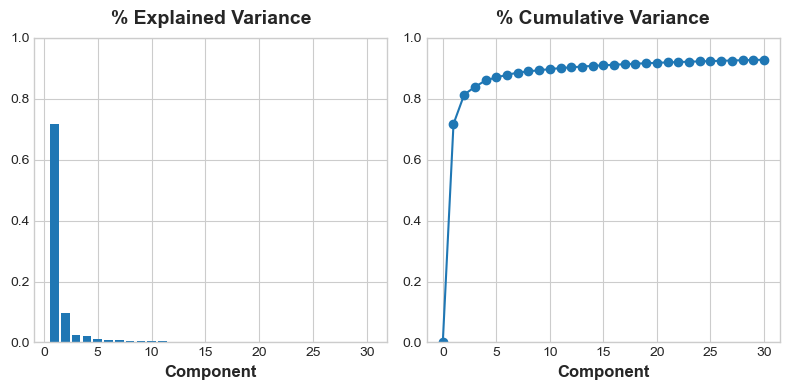

In [37]:
plot_variance(pca)

In [20]:
def make_mi_scores(X,y,discrete_features):
    mi_scores = mutual_info_regression(X,y,discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores=mi_scores.sort_values(ascending=False)
    return mi_scores

def score_model(model, X_t=X_train, y_t=y_train, X_te=X_test, y_te=y_test):
    model.fit(X_t,y_t)
    preds=model.predict(X_te)
    return f1_score (y_te,preds,average='weighted')

def conf_matx(model, y_te=y_test, X_te=X_test):
    
    #Variable target avec les labels organisées:
    y_organised = ['10','2280','2403','2705','2522',
               '40','50','2905','2462','60',
               '1280','1281','1300','1180','1140','1160',
               '1320','1560',
               '2582','2583','2585','1302','2220',
               '1920','2060',
               '1301','1940']
    
    
    preds=model.predict(X_te)
    cnf_matrix = metrics.confusion_matrix(y_test,preds,labels=y_organised)
    y_organised

    pond_matrix = []
    for line in cnf_matrix:
        pond_line = []
        for cell in line:
            pond_line.append(round(cell/sum(line),2))
        pond_matrix.append(pond_line)
    cnf_matrix = np.array(pond_matrix)
    classes = y_organised

    plt.figure(figsize=(17,17))

    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

    plt.ylabel('Y TRUE')
    plt.xlabel(' PREDICTION')
    plt.show()

In [21]:
mi_scores=make_mi_scores(X_pca, target, discrete_features=False)
mi_scores

PC3     0.279721
PC2     0.132753
PC14    0.104139
PC7     0.096233
PC5     0.093427
PC12    0.089375
PC21    0.083709
PC4     0.073384
PC8     0.069693
PC6     0.067522
PC20    0.066888
PC26    0.058420
PC10    0.057771
PC11    0.055970
PC27    0.054056
PC15    0.050638
PC9     0.049675
PC18    0.041279
PC13    0.037481
PC19    0.035428
PC30    0.034415
PC28    0.033434
PC22    0.030712
PC16    0.029206
PC17    0.028610
PC25    0.027216
PC23    0.024458
PC29    0.021469
PC24    0.016353
PC1     0.003269
Name: MI Scores, dtype: float64

In [22]:
pca.fit(data)
print("composantes retenues :", pca.n_components_)

composantes retenues : 30


In [23]:
pca = PCA(n_components = 30)
X_train = data[:20000]
X_test = data[20000:]
X_train_scaled = X_train /255
X_test_scaled = X_test /255
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [24]:
y_train = y[X_train.index]
y_test = y[X_test.index]
print(y_train.shape, y_test.shape)

(20000,) (10000,)


In [25]:
# mod 1 
from sklearn.ensemble import RandomForestClassifier
m1_rf = RandomForestClassifier(n_jobs = -1, random_state=1)
score_model(m1_rf, X_train_pca, y_train, X_test_pca, y_test)

0.31923650664283526

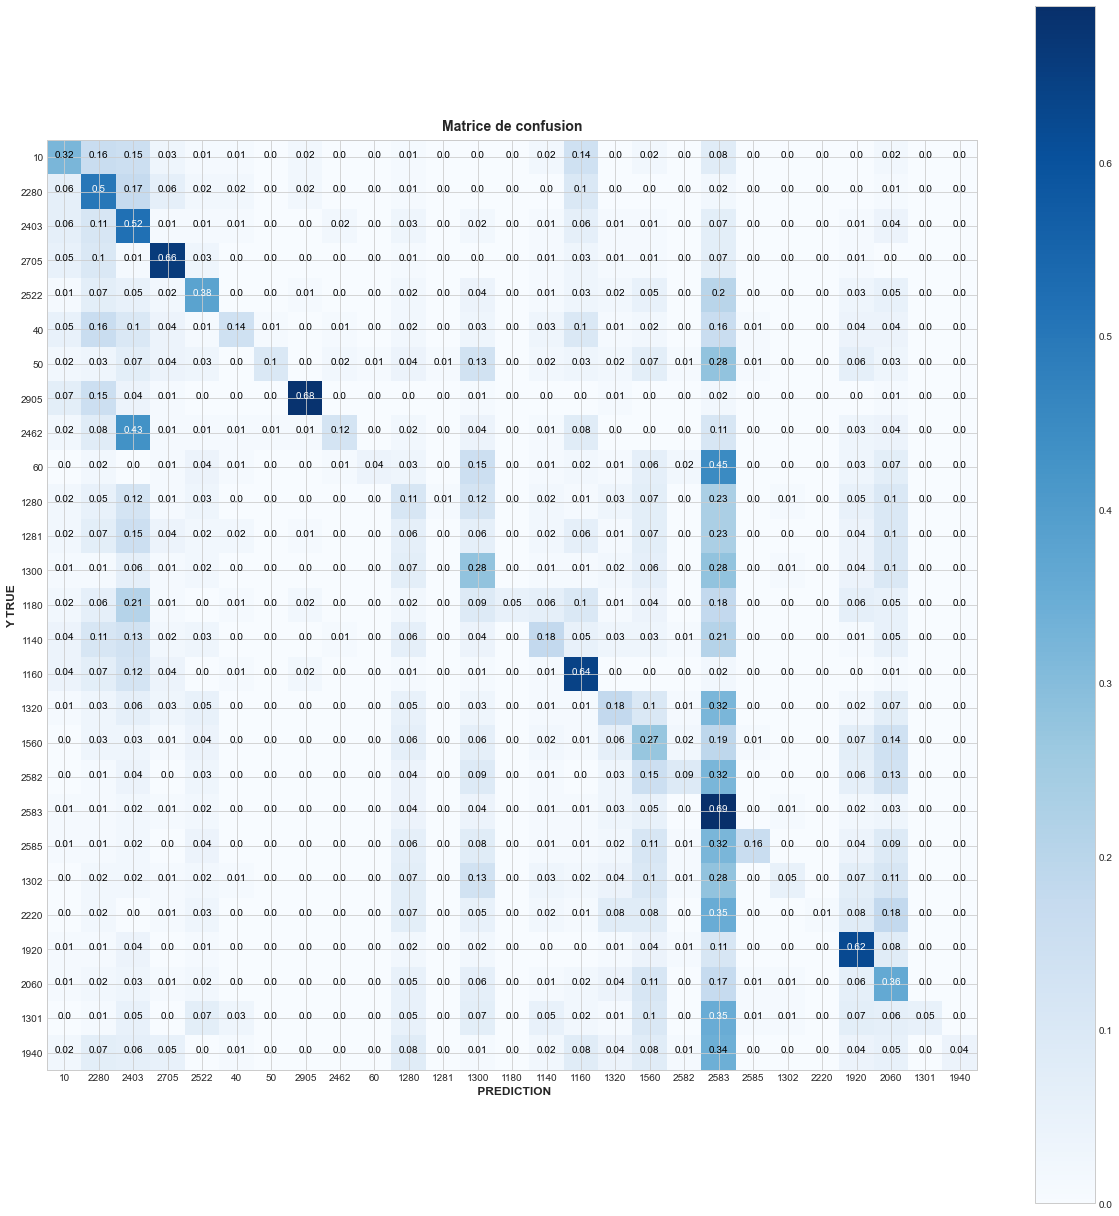

In [26]:
conf_matx(m1_rf,y_test,X_test_pca)

In [27]:
# mod 2 XGBOOST
# from xgboost import XGBClassifier
m2_xgb = XGBClassifier(n_jobs = -1)
score_model(m2_xgb, X_train_pca, y_train, X_test_pca, y_test)

C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:59:06] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.2898210086005525

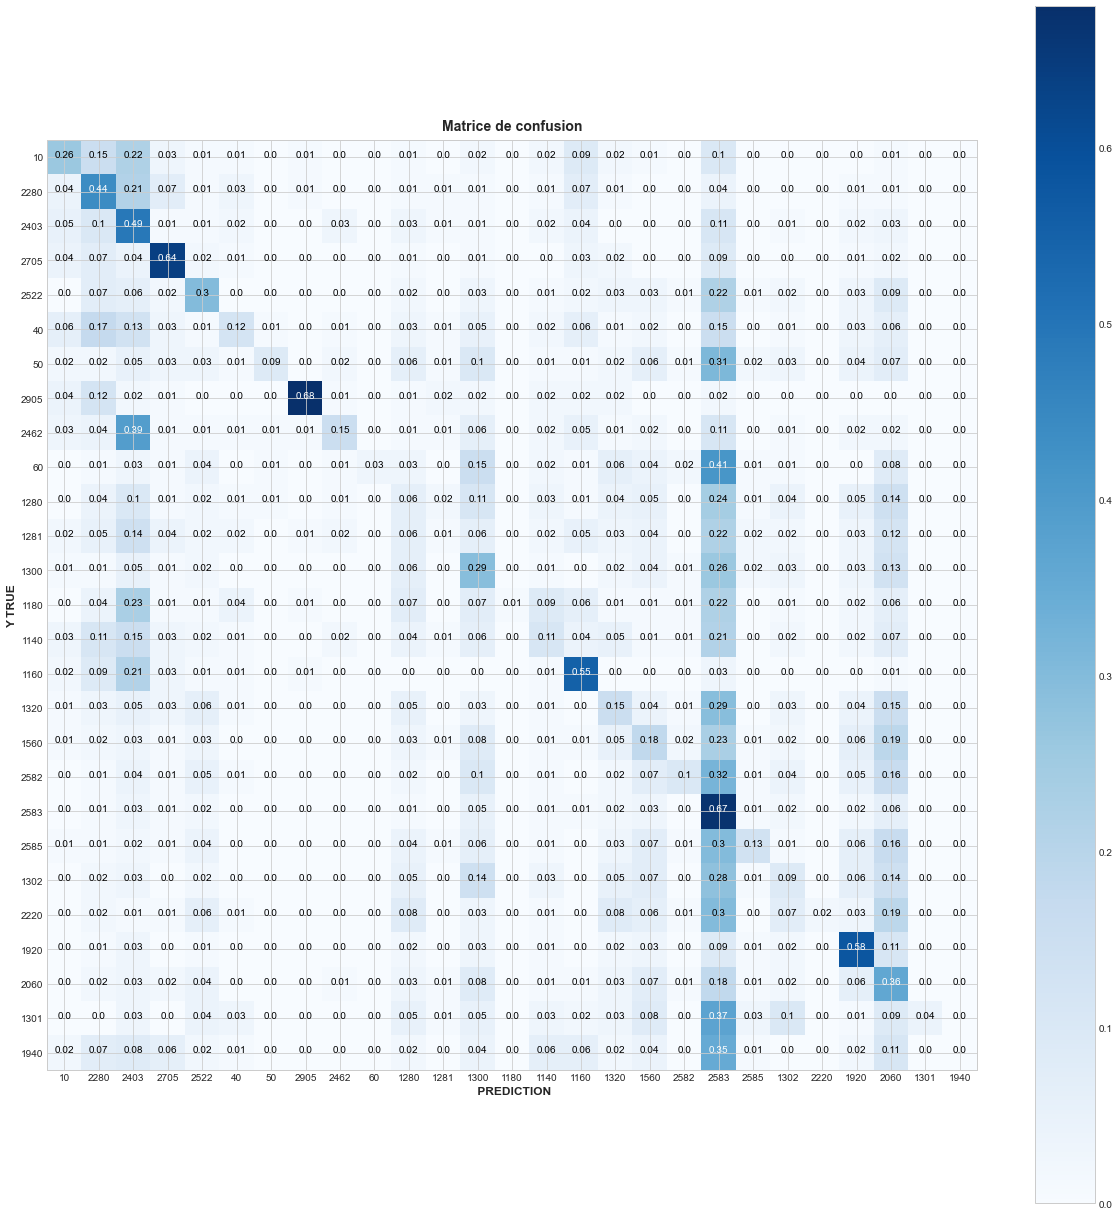

In [28]:
conf_matx(m2_xgb,y_test,X_test_pca)

In [33]:
preds=m2_xgb.predict(X_test_pca)

In [39]:
preds

array(['1560', '2403', '1300', ..., '1140', '1920', '2060'], dtype=object)

In [46]:
indexes = [i for i in range(len(preds))]
indexes

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [ ]:
images = 8
j=1
plt.figure(figsize = (20,20))
#plt.subplot(10,5,1)
plt.axis('off')

for i in np.random.choice(indexes, size = images):
    #img = cv2.imread(path + '\\' + X_test_pca[i]['image_name'])  #X['image_path']
    img = cv2.imread(path + '\\' + X[i]['image_name'])
    img = cv2.resize(img, (240, 240), interpolation=cv2.INTER_CUBIC)
    #img = cv2.imread(path + '\\' + X_test_img.iloc[0]['image_name'], cv2.IMREAD_COLOR)
    #img = img.reshape(28, 28)
      
    plt.subplot(4,2,j)
    j = j + 1
    plt.axis('off')
    plt.imshow(img, cmap=cm.binary, interpolation='None')
    plt.title('True Label: ' + classes[str(y_te[i])] + '\n' + 'Prediction: '+ classes[str(preds[i])] )
             #+ '\n' + 'Confidence: '+ str(round(np.max(y_pred_prob, axis=1)[i],2)))